In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import norm, t

In [2]:
ab_data = pd.read_csv('ab_data_tourist.csv')

##  Структура данных

In [3]:
ab_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [5]:
ab_data['date'] = pd.to_datetime(ab_data['date'], format='%Y-%m-%d')

In [6]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


Пропусков данных нет

In [7]:
a_data = ab_data[ab_data['group'] == 'A']
b_data = ab_data[ab_data['group'] == 'B']

In [8]:
if a_data['date'].min() == b_data['date'].min() and a_data['date'].max() == b_data['date'].max():
       print('Длительности проведения A/B-тестирования в каждой из группе одинаковая')

Длительности проведения A/B-тестирования в каждой из группе одинаковая


In [9]:
dublicates = list(b_data[b_data['user_id'].isin(a_data['user_id'].unique())]['user_id'])
if dublicates == []:
    print('Пользователи, которые в процессе A/B-теста попали в обе группы отсутствуют')
else:
    print(f'Пользователи, которые в процессе A/B-теста попали в обе группы присутствуют в количестве {len(dublicates)}')    

Пользователи, которые в процессе A/B-теста попали в обе группы присутствуют в количестве 1895


In [10]:
# Удаление строк, где user_id содержится в списке dublicates
ab_data_clear = ab_data[~ab_data['user_id'].isin(dublicates)]
a_data = ab_data_clear[ab_data_clear['group'] == 'A']
b_data = ab_data_clear[ab_data_clear['group'] == 'B']

##  Первичный анализ результатов A/B-тестирования

In [11]:
#   Вспомогательные показатели для контрольной  группы (А):
print(f'Количество посещений сайта: {a_data.shape[0]}')
print(f'Суммарное количество совершённых покупок: {a_data.purchase.sum()}')
print(f'Сумма всех покупок: {a_data.price.sum()}')


Количество посещений сайта: 145307
Суммарное количество совершённых покупок: 17487
Сумма всех покупок: 1417780000


In [12]:
#   Вспомогательные показатели для тестовой  группы (B):
print(f'Количество посещений сайта: {b_data.shape[0]}')
print(f'Суммарное количество совершённых покупок: {b_data.purchase.sum()}')
print(f'Сумма всех покупок: {b_data.price.sum()}')

Количество посещений сайта: 145381
Суммарное количество совершённых покупок: 17290
Сумма всех покупок: 1533010000


Первоначальные выводы  можно сделать следующие:
* Количество посещений сайта практически одинаково для контрольной (145307) и тестовой (145381) групп. Разница в количестве посещений незначительна.
* Суммарное количество совершённых покупок в контрольной группе (17487) немного выше, чем в тестовой группе (17290). Однако разница не критична.
* Сумма всех покупок в контрольной группе равна 1417780000, в то время как в тестовой группе она составляет 1533010000. 
   Тестовая группа (группа B) показывает более высокую сумму всех покупок, чем контрольная группа (группа A).
   
   Несмотря на схожее количество посещений сайта и примерно одинаковое количество совершенных покупок, тестовая группа имеет более высокую сумму всех покупок. 
   Это может говорить о том, что изменения, внесенные в тестовую группу, имели положительный эффект на выручку. 
   Для получения более точных выводов и подтверждения значимости различий между группами, требуется дальнейшее изучения результатов тестирования обеих групп.   

In [13]:
# Ключевые показатели
print(f'Конврсия для группы А : {round(100 * a_data.purchase.sum() / a_data.shape[0], 2)}')
print(f'Конврсия для группы B : {round(100 * b_data.purchase.sum() / b_data.shape[0], 2)}')
print('-------------------------------')
print(f'Средний чек группы А : {round(a_data.price.sum() / a_data.purchase.sum(), 2)}')
print(f'Средний чек группы B : {round(b_data.price.sum() / b_data.purchase.sum(), 2)}')

Конврсия для группы А : 12.03
Конврсия для группы B : 11.89
-------------------------------
Средний чек группы А : 81076.23
Средний чек группы B : 88664.55


1. Конверсия:
   - Конверсия группы A равна 12.03%, в то время как конверсия группы B составляет 11.89%.
   - Несмотря на небольшое различие в конверсии между группами, данная разница может быть статистически незначимой.

2. Средний чек:
   - Средний чек в группе A составляет 81076.23, в то время как средний чек в группе B равен 88664.55.
   - Группа B имеет более высокий средний чек по сравнению с группой A.

3. Выводы:
   - Понижение конверсии в группе B и заметный рост среднего чека свидетельствуют о том, что изменения, примененные в группе B, могли привести к увеличению среднего чека на столько, чтобы перекрыть убытки от незначительного падения конверсии.
   - Для получения более точных выводов и подтверждения значимости различий между группами, требуется дальнейшее изучения результатов тестирования обеих групп


In [14]:
# Создание сводной таблицы
pivot_table = pd.pivot_table(ab_data_clear, values='purchase', index='group', columns='price', aggfunc=np.sum, fill_value=0)
pivot_table = pivot_table.drop(0, axis=1)
pivot_table = pivot_table.rename(columns={10000: 'Санкт-Петербург', 60000: 'Турция', 100000: 'Таиланд',
                                         150000: 'Камчатка', 200000: 'Мальдивы'})

In [15]:
pivot_table

price,Санкт-Петербург,Турция,Таиланд,Камчатка,Мальдивы
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


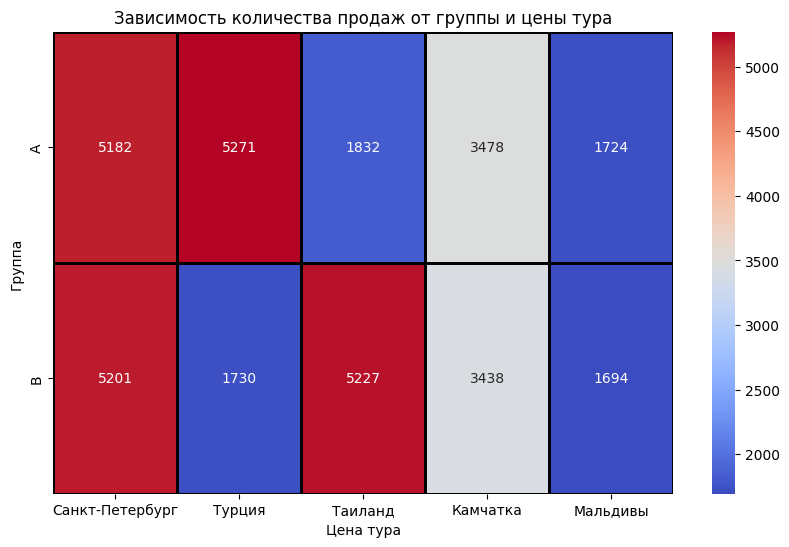

In [16]:
# Визуализация сводной таблицы
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='g',linewidths=2, linecolor='black', cmap='coolwarm')
plt.title('Зависимость количества продаж от группы и цены тура')
plt.xlabel('Цена тура')
plt.ylabel('Группа')
plt.show()

1. Группа A:
   - Наибольшее количество продаж в группе A было достигнуто для направления Турция, где количество продаж составило 5271.
   - Для напрвлений Санкт-Петербург и Мальдивы количество продаж также имеет относительно высокие значения.
   - Наименьшее количество продаж в группе A прослеживается для направления Тайланд.

2. Группа B:
   - Для группы B наибольшее количество продаж наблюдается для направления Тайланд, где было реализовано 5227 продаж.
   - Направление Санкт-Петербург также показывает высокое количество продаж в группе B (5201).
   - Наименьшее количество продаж в группе B приходится для направления Турция.

3. Сравнение групп:
   - Группы A и B демонстрируют различное поведение в зависимости от ценовой категории: например, группа A показывает более высокие продажи для направления Турция, в то время как группа B преуспевает в продажах для направления Тайланд.

## Анализ данных на предмет стабилизации метрик

In [17]:
df_a = a_data.groupby('date').agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'client_count'})
df_a.head()

,date,client_count,purchase,price
0,2021-01-02,2854,359,29410000
1,2021-01-03,6596,748,62000000
2,2021-01-04,6566,799,64250000
3,2021-01-05,6433,790,64550000
4,2021-01-06,6606,764,63410000


In [18]:
df_b = b_data.groupby('date').agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'client_count'})
df_b.head()

,date,client_count,purchase,price
0,2021-01-02,2861,345,29660000
1,2021-01-03,6619,754,65960000
2,2021-01-04,6536,764,68030000
3,2021-01-05,6511,749,63550000
4,2021-01-06,6751,838,75020000


In [19]:
# информация о ежедневной конверсии в группе и о ежедневном среднем чеке
df_a['convers_day'] = round(100 * df_a['purchase'] / df_a['client_count'], 2)
df_b['convers_day'] = round(100 * df_b['purchase'] / df_b['client_count'], 2)

df_a['mean_check'] = round(df_a['price'] / df_a['purchase'], 2)
df_b['mean_check'] = round(df_b['price'] / df_b['purchase'], 2)
display(df_a.head())
display(df_b.head())

,date,client_count,purchase,price,convers_day,mean_check
0,2021-01-02,2854,359,29410000,12.58,81922.01
1,2021-01-03,6596,748,62000000,11.34,82887.70
2,2021-01-04,6566,799,64250000,12.17,80413.02
3,2021-01-05,6433,790,64550000,12.28,81708.86
4,2021-01-06,6606,764,63410000,11.57,82997.38


,date,client_count,purchase,price,convers_day,mean_check
0,2021-01-02,2861,345,29660000,12.06,85971.01
1,2021-01-03,6619,754,65960000,11.39,87480.11
2,2021-01-04,6536,764,68030000,11.69,89044.50
3,2021-01-05,6511,749,63550000,11.50,84846.46
4,2021-01-06,6751,838,75020000,12.41,89522.67


In [20]:
# объявляем функцию для расчёта кумулятивных показателей
def calculate_cum(data):
    data['cum_users_count'] = data['client_count'].cumsum()
    data['cum_purchase'] = data['purchase'].cumsum()
    data['cum_price'] = data['price'].cumsum()
    data['cum_conversion'] = data['cum_purchase']/data['cum_users_count'] * 100
    data['cum_mean_check'] = data['cum_price']/data['cum_purchase']
    return data

# применяем функцию для каждого набора данных:
daily_sample_a = calculate_cum(df_a)
daily_sample_b = calculate_cum(df_b)

display(daily_sample_a.head())
display(daily_sample_b.head())

,date,client_count,purchase,price,convers_day,mean_check,cum_users_count,cum_purchase,cum_price,cum_conversion,cum_mean_check
0,2021-01-02,2854,359,29410000,12.58,81922.01,2854,359,29410000,12.578837,81922.005571
1,2021-01-03,6596,748,62000000,11.34,82887.70,9450,1107,91410000,11.714286,82574.525745
2,2021-01-04,6566,799,64250000,12.17,80413.02,16016,1906,155660000,11.900599,81668.415530
3,2021-01-05,6433,790,64550000,12.28,81708.86,22449,2696,220210000,12.009444,81680.267062
4,2021-01-06,6606,764,63410000,11.57,82997.38,29055,3460,283620000,11.908449,81971.098266


,date,client_count,purchase,price,convers_day,mean_check,cum_users_count,cum_purchase,cum_price,cum_conversion,cum_mean_check
0,2021-01-02,2861,345,29660000,12.06,85971.01,2861,345,29660000,12.058721,85971.014493
1,2021-01-03,6619,754,65960000,11.39,87480.11,9480,1099,95620000,11.592827,87006.369427
2,2021-01-04,6536,764,68030000,11.69,89044.50,16016,1863,163650000,11.632118,87842.190016
3,2021-01-05,6511,749,63550000,11.50,84846.46,22527,2612,227200000,11.594975,86983.154671
4,2021-01-06,6751,838,75020000,12.41,89522.67,29278,3450,302220000,11.783592,87600.000000


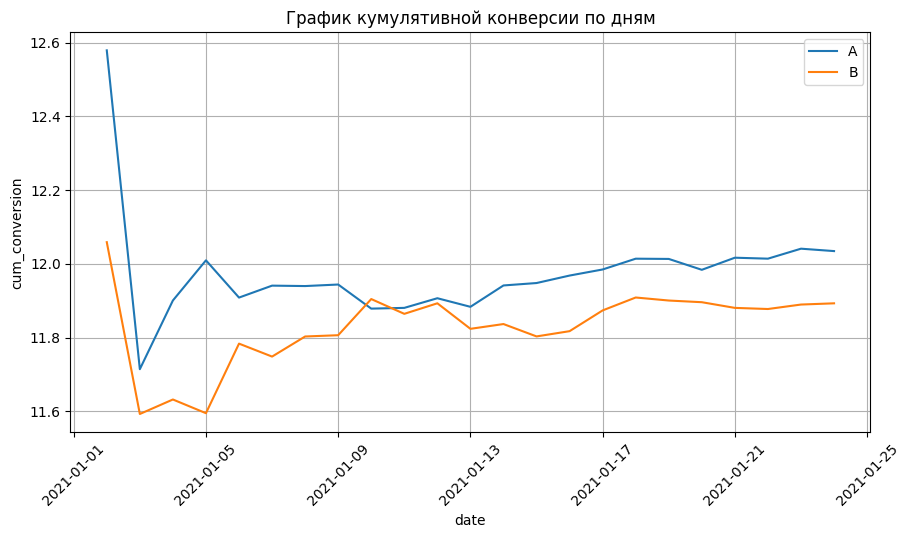

In [21]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_sample_a, ax=ax, label = 'A')
sns.lineplot(x='date', y='cum_conversion', data=daily_sample_b, ax=ax, label = 'B')
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

До 2021-01-13 конверсия была нестабильна, но после 2021-01-13 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

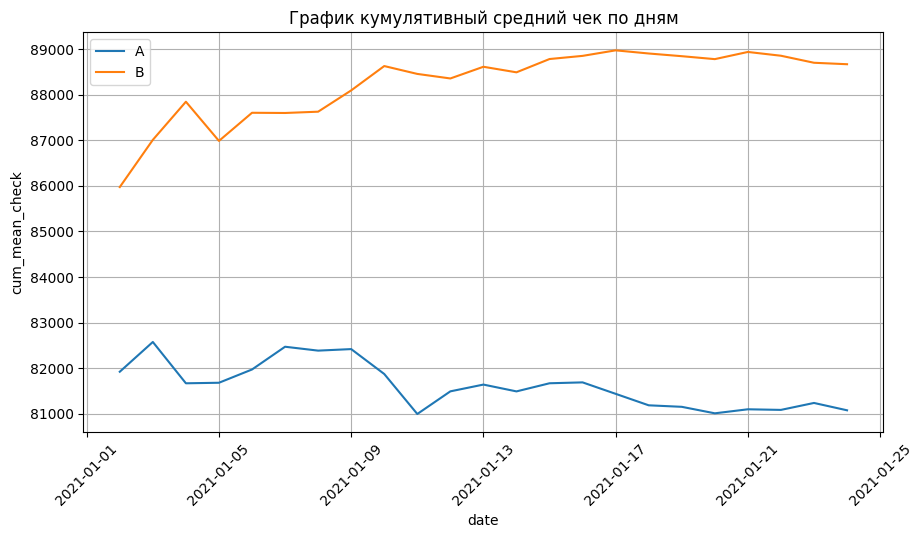

In [22]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=daily_sample_a, ax=ax, label = 'A')
sns.lineplot(x='date', y='cum_mean_check', data=daily_sample_b, ax=ax, label = 'B')
# задаём подпись к графику
ax.set_title('График кумулятивный средний чек по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

*  По графику, кумулятивный средний чек группы А стабильно хуже конверсии группы В на всём промежутке времени. 
*  График группы А показывает спад на всем промежутке времени, в тоже время график группы В наоборот постепенный рост.

## Статистический анализ результатов A/B-тестирования

Выдвигаем гипотезы:

 * Нулевая (об отсутствии эффекта): конверсии в группах A и B равны.
 * Альтернативная (о наличии эффекта): конверсии в группах A и B не равны.

In [23]:
alpha = 0.05

In [24]:
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=[a_data['purchase'].sum(), b_data['purchase'].sum()], # число «успехов»
    nobs=[a_data['user_id'].count(), b_data['user_id'].count()], # общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.24
У нас нет оснований отвергнуть нулевую гипотезу


Итак, p-value = 0.24, что больше уровня значимости alpha = 0.05. Значит, мы не можем отвергнуть нулевую гипотезу о равенстве конверсий в группах. С точки зрения бизнеса это означает, что варианты A и B равнозначны по метрике конверсии.

Построим гистограмму среднего чека, который потратили пользователи  в каждой из групп:

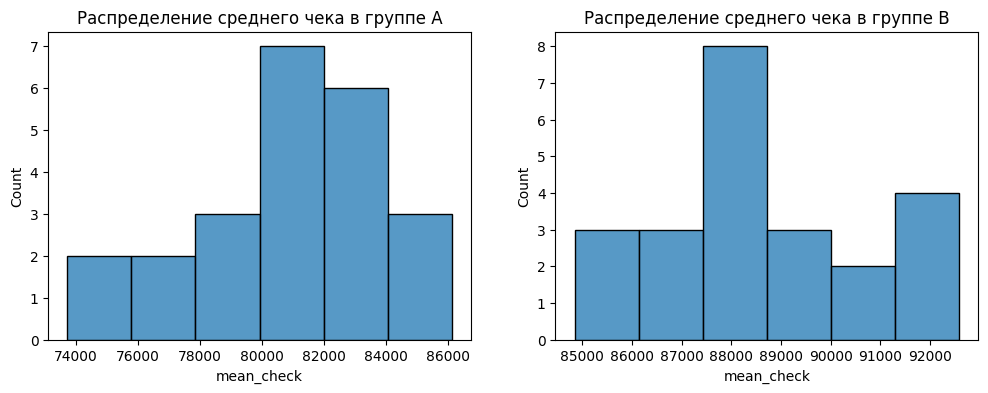

In [25]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='mean_check', data=daily_sample_a, ax=axes[0])
sns.histplot(x='mean_check', data=daily_sample_b, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

Визуально можно предположить, что значения среднего чека в группе А распределенно нормально, по группе В такое утверждение сложно выдвинуть, для полного вывода о нормальности рапределения проведем  тест Шапиро — Уилка для выборок

In [26]:
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(daily_sample_a['mean_check'])
shapiro_result_b = shapiro(daily_sample_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом, чтобы сравнить средний чек в группах.

* Нулевая гипотеза (об отсутствии эффекта): среднее чек из группы А, равен среднему чеку из группы B
* Альтернативная гипотеза (о наличии эффекта): среднее чек из группы А, отличается среднему чеку из группы B

In [27]:
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_sample_a['mean_check'],
    b=daily_sample_b['mean_check'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Итак, p-value = 0, что меньше уровня значимости alpha = 0.05  . Значит, мы  можем отвергнуть нулевую гипотезу о равенстве средних чеков в группах. С точки зрения бизнеса это означает, что варианты A и B не равнозначны по метрике ежедневного среднего чека.

## Доверительные интервалы

#### Конверсия в каждой из групп

In [28]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

In [29]:
# Для группы А
n_a = a_data.shape[0] # размер выборки
positive_a = a_data.purchase.sum() # число положительных исходов
xp_a = positive_a/n_a # выборочная пропорция

# Для группы B
n_b = b_data.shape[0] # размер выборки
positive_b = b_data.purchase.sum() # число положительных исходов
xp_b = positive_b/n_b # выборочная пропорция


In [30]:
# строим доверительный интервал для групп A и В
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=xp_a,
    n=n_a 
)

lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=xp_b, 
    n=n_b 
)


In [31]:
print('Доверительный интервал для группы A: ({:.2f} , {:.2f})'.format(lower_bound_a * 100, upper_bound_a * 100))
print('Доверительный интервал для группы B: ({:.2f} , {:.2f})'.format(lower_bound_b * 100, upper_bound_b * 100))

Доверительный интервал для группы A: (11.87 , 12.20)
Доверительный интервал для группы B: (11.73 , 12.06)


Конверсия в обеих группах достаточно близки друг к другу, при этом доверительные интервалы перекрываются. Это может свидетельствовать о том, что статистически значимых различий между значений конверсий в группах A и B быть не должно

### Разницы конверсий в группах


In [32]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [33]:
n = ab_data_clear.shape[0] # размер выборки обеих групп
n_positive_a = positive_a # число пользователей, совершивших конверсию, в группе А
n_positive_b = positive_b # число пользователей, совершивших конверсию, в группе B
xp_a = n_positive_a/n # выборочная пропорция группы A
xp_b = n_positive_b/n # выборочная пропорция группы B

In [34]:
# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(
    x_p=[xp_a, xp_b],
    n=[n, n]
)


# выводим результат
print('Доверительный интервал для разности конверсий: ({:.2f}, {:.2f})'.format(lower_bound * 100, upper_bound * 100))

Доверительный интервал для разности конверсий: (-0.19, 0.05)


Доверительный интервал для разности конверсий (-0.19, 0.05) указывает на то, что с 95% уверенностью разница между конверсиями в группах может лежать в пределах от -0.19 до 0.05. Данный интервал включает ноль, что означает, что существует вероятность того, что различия в конверсиях между группами не являются статистически значимыми.

Выводы:
- Между группой A и группой B нет статистически значимых различий в конверсиях на уровне значимости 0.05.
- Данный доверительный интервал позволяет нам оценить диапазон возможных значений разницы конверсий между группами с достаточным уровнем доверия.

### Ежедневный средний чек в каждой из групп.

In [35]:
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

In [36]:
# Для группы А
n_a = df_a.shape[0] # размер выборки
k = n_a - 1 # число степеней свободы
xa_mean = df_a.mean_check.mean() # выборочное среднее
xa_std = df_a.mean_check.std() # выборочное стандартное отклонение

# Для группы B
n_b = df_b.shape[0] 
k = n_b - 1 
xb_mean = df_b.mean_check.mean() 
xb_std = df_b.mean_check.std() 

In [37]:
lower_bound_a, upper_bound_a = t_mean_conf_interval(xa_mean, xa_std, n_a)
lower_bound_b, upper_bound_b = t_mean_conf_interval(xb_mean, xb_std, n_b)

print('Доверительный интервал по среднему чеку для группы А: {}'.format((round(lower_bound_a), round(upper_bound_a))))
print('Доверительный интервал по среднему чеку для группы В: {}'.format((round(lower_bound_b), round(upper_bound_b))))

Доверительный интервал по среднему чеку для группы А: (79630, 82308)
Доверительный интервал по среднему чеку для группы В: (87626, 89526)


Выводы:
- Средний чек в группе B значительно выше, чем в группе A, поскольку доверительный интервал для группы B находится выше интервала для группы A.
- Разница между средними чеками группы B и группы A статистически значима на уровне доверия 95%, так как интервалы не пересекаются.

# Выводы

#### 1. Количество посещений сайта: 
Количество посещений сайта в контрольной и тестовой группах практически одинаково, что указывает на равномерное распределение пользователей между группами.

#### 2. Количество совершенных покупок: 
Хотя количество совершенных покупок в контрольной группе немного выше, чем в тестовой, разница не является критичной.

#### 3. Сумма всех покупок: 
Тестовая группа (группа B) показывает более высокую сумму всех покупок по сравнению с контрольной группой (группа A). Это может свидетельствовать о положительном влиянии изменений, внесенных в тестовую группу, на выручку.

#### 4. Конверсия: 
Конверсия в группе A немного выше, чем в группе B, однако разница может быть статистически незначимой.

#### 5. Средний чек: 
Группа B имеет более высокий средний чек по сравнению с группой A.

#### 6. Анализ продаж по направлениям:
   - В группе A наибольшее количество продаж наблюдается для направления Турция, а в группе B - для направления Тайланд.
   - Обе группы показывают высокое количество продаж для направления Санкт-Петербург.
   - Наименьшее количество продаж в группе A приходится на направление Тайланд, а в группе B - на направление Турция.
   - Существенной разници приобретения туров в группах нет,кроме двух (Турция и Тайланд). Т.к. тур Тайланд стоит дороже и в группе В данного направления больше, а в группе А больше более дешевого из этих двух туров (Турция), можно предположить за счет этого фактора средний чек увеличился. Возможно в варианте А была акция по направлению Турция, в варианте В Тайланд.